                                             log_file  reducers
0   /user/hadoop/results/300MB.txt/Combiner/10redu...        10
1   /user/hadoop/results/300MB.txt/Combiner/10redu...        10
2   /user/hadoop/results/300MB.txt/Combiner/3reduc...         3
3   /user/hadoop/results/300MB.txt/Combiner/3reduc...         3
4   /user/hadoop/results/300MB.txt/Combiner/5reduc...         5
5   /user/hadoop/results/300MB.txt/Combiner/5reduc...         5
6   /user/hadoop/results/300MB.txt/InMapper/10redu...        10
7   /user/hadoop/results/300MB.txt/InMapper/10redu...        10
8   /user/hadoop/results/300MB.txt/InMapper/3reduc...         3
9   /user/hadoop/results/300MB.txt/InMapper/3reduc...         3
10  /user/hadoop/results/300MB.txt/InMapper/5reduc...         5
11  /user/hadoop/results/300MB.txt/InMapper/5reduc...         5


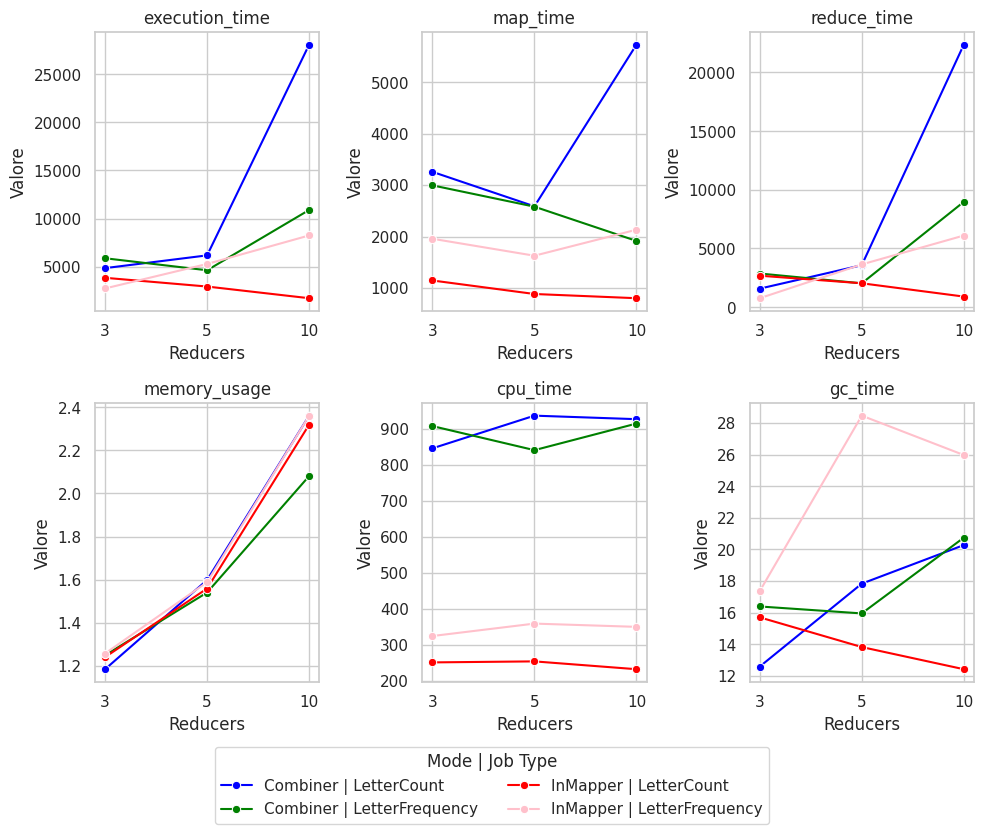

Grafico salvato in plot/performances_comparison_correct.png


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib import ticker
import re

# Leggi il file CSV
file_path = 'Hadoop_job_data.csv'
df = pd.read_csv(file_path, sep=';')

# Aggiungi colonne per dimensione del job, modalità e numero di reducer
df['job_size'] = df['log_file'].apply(lambda x: x.split('/')[4])
df['mode'] = df['log_file'].apply(lambda x: x.split('/')[5])

# Correggi l'estrazione dei reducers con regex
def extract_reducers(log_file):
    match = re.search(r'/(\d+)reducers', log_file)
    if match:
        return int(match.group(1))
    return 1

df['reducers'] = df['log_file'].apply(extract_reducers)

# Conferma i dati estratti
print(df[['log_file', 'reducers']])

# Crea una mappatura per valori fittizi delle x
reducers_mapping = {3: 1, 5: 2, 10: 3}
df['reducers_mapped'] = df['reducers'].map(reducers_mapping)

# Melt dei dati
df_melted = df.melt(id_vars=['job_size', 'mode', 'reducers', 'reducers_mapped', 'job_type'], var_name='param', value_name='value')
df_melted['workflow_job'] = df_melted['mode'] + ' | ' + df_melted['job_type']

# Crea la cartella plot se non esiste
output_dir = 'plot'
os.makedirs(output_dir, exist_ok=True)

# Imposta lo stile dei grafici
sns.set(style="whitegrid")

# Definisci la palette
palette = {
    "Combiner | LetterCount": "Blue",
    "Combiner | LetterFrequency": "Green",
    "InMapper | LetterCount": "Red",
    "InMapper | LetterFrequency": "Pink",
}

# Lista dei parametri da confrontare
params_to_plot = [
    'execution_time',
    'map_time',
    'reduce_time',
    'memory_usage',
    'cpu_time',
    'gc_time'
]

# Filtro dei parametri per evitare errori in caso di mancanza di dati
df_melted_filtered = df_melted[df_melted['param'].isin(params_to_plot)]

# Crea la griglia delle faccette
g = sns.FacetGrid(df_melted_filtered, row="param", col="job_size", hue="workflow_job", sharey=False, height=4, aspect=2, palette=palette)

# Genera i plot con linee distinte per reducers
g.map_dataframe(sns.lineplot, x="reducers_mapped", y="value", marker='o')

# Aggiungi la legenda
g.add_legend(loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, title='Mode | Job Type')

# Configura gli assi e i titoli
for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(ticker.FixedLocator([1, 2, 3]))
    ax.set_xticklabels(['3', '5', '10'])  # Assicurati che i valori di reducers siano equidistanti
    ax.set_ylabel('Valore')
    ax.set_xlabel('Reducers')

# Aggiusta i titoli
g.set_titles(row_template="{row_name}", col_template="Dimensione del file = {col_name}")

# Salva il grafico
plt.tight_layout()
output_path = os.path.join(output_dir, 'performances_comparison_correct.png')
plt.savefig(output_path, bbox_inches='tight')
plt.show()

print(f"Grafico salvato in {output_path}")
